<h1><b>Carbon Footprint Engine - Integration of GHG emitting events</b></h1>
<h1><b>Scope 1 - Purchased Goods and Services</b></h1>

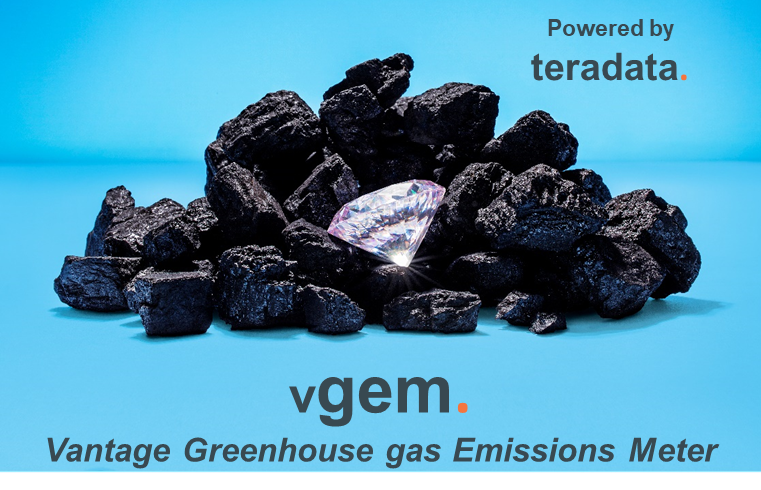

<p><b>This script integrates Scope 3 - Purchased Goods and Services data to the carbon footprint engine</b></p>

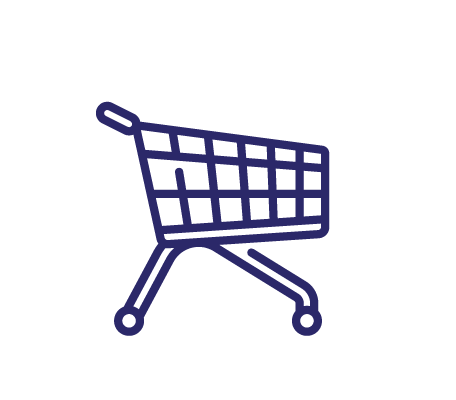

<h1>Settings</h1>

In [2]:
%var vantageInstance               = "Transcend-Production-AWS"
    ,workingDatabase               = "ADLSLSEMEA_Scope3"
    ,volatileTablePrefixe          = "VOL_"
    ,georefPrefixe                 = "GEO_"
    ,greenAgendaPrefixe            = "GA2_"
    ,foreignTablePrefixe           = "FT_"
    ,stagingTablePrefixe           = "STG_"
    ,coreTablePrefixe              = "CORE_"
    ,authReadNOS                   = "GA_auth_read_nos"
    ,objectStoreInputDataBucketURL = "/gs/storage.googleapis.com/green-agenda/"

<h2>Entities (tables)</h2>

In [3]:
%var tbSrcPurchasedProducts = "Purchased_products"
    ,tbActRef               = "Activity_ref"
    ,tbActTagRef            = "Activity_tag_ref"
    ,tbProtocolRef          = "Protocol_ref"
    ,tbEmissionRef          = "Emission_ref"
    ,tbGhgEmissEvt          = "GHG_emission_event"
    ,tbGhgEmissEvtGp        = "GHG_emission_event_group"
    ,tbPurchaseEvt          = "Purchase_event"

<h1>Connection to Vantage</h1>

In [4]:
%connect ${vantageInstance}

Success: 'Transcend-Production-AWS' connection established and activated for user 'gl186002'


<h1>Creation of the "Purchased products" foreign and staging tables</h1>

In [4]:
drop table ${workingDatabase}.${greenAgendaPrefixe}${foreignTablePrefixe}${tbSrcPurchasedProducts};

Success: 43 rows affected

In [5]:
create foreign table ${workingDatabase}.${greenAgendaPrefixe}${foreignTablePrefixe}${tbSrcPurchasedProducts}
 ,external security invoker trusted ${authReadNOS}
  using(location('${objectStoreInputDataBucketURL}GHGEmissionEvents/Scope3/01_purchased_goods_and_services/'))
;

Success: 0 rows affected

WARNING: [Teradata Database] [Warning 4968] Unsupported record_delimiter:'
'. Table Created: with record_delimiter value:'\n'.Use READ_NOS RAW mode to determine the delimiters.

In [6]:
select top 10 * from ${workingDatabase}.${greenAgendaPrefixe}${foreignTablePrefixe}${tbSrcPurchasedProducts};

,Location,supplier,purchase_element,purchase_type,purchase_item,purchase_unit,purchase_quantity,supplier_emission_factor,purchase_begin_period,purchase_end_period
1,/GS/storage.googleapis.com/green-agenda/GHGEmissionEvents/Scope3/01_purchased_goods_and_services/GHGP_examples_purchased_products_2022.csv,Supplier E,Paint,Purchased good,Whole product,kilogram,200000,.10,2022-01-01,2023-01-01
2,/GS/storage.googleapis.com/green-agenda/GHGEmissionEvents/Scope3/01_purchased_goods_and_services/GHGP_examples_purchased_products_2022.csv,Supplier G,Concrete,Purchased good,Whole product,kilogram,50000,.20,2022-01-01,2023-01-01
3,/GS/storage.googleapis.com/green-agenda/GHGEmissionEvents/Scope3/01_purchased_goods_and_services/GHGP_examples_purchased_products_2022.csv,,Hard-drives,Purchased good,Whole product,kilogram,400,,2022-01-01,2023-01-01
4,/GS/storage.googleapis.com/green-agenda/GHGEmissionEvents/Scope3/01_purchased_goods_and_services/GHGP_examples_purchased_products_2022.csv,,Integrated circuits,Purchased good,Whole product,kilogram,200,,2022-01-01,2023-01-01
5,/GS/storage.googleapis.com/green-agenda/GHGEmissionEvents/Scope3/01_purchased_goods_and_services/GHGP_examples_purchased_products_2022.csv,,Semiconductors,Purchased good,Whole product,kilogram,100,,2022-01-01,2023-01-01
6,/GS/storage.googleapis.com/green-agenda/GHGEmissionEvents/Scope3/01_purchased_goods_and_services/GHGP_examples_purchased_products_2022.csv,,Battery,Purchased good,Whole product,kilogram,1500,,2022-01-01,2023-01-01
7,/GS/storage.googleapis.com/green-agenda/GHGEmissionEvents/Scope3/01_purchased_goods_and_services/GHGP_examples_purchased_products_2022.csv,,LCD,Purchased good,Whole product,kilogram,500,,2022-01-01,2023-01-01
8,/GS/storage.googleapis.com/green-agenda/GHGEmissionEvents/Scope3/01_purchased_goods_and_services/GHGP_examples_purchased_products_2022.csv,Supplier F,Timber,Purchased good,Whole product,kilogram,100000,.25,2022-01-01,2023-01-01
9,/GS/storage.googleapis.com/green-agenda/GHGEmissionEvents/Scope3/01_purchased_goods_and_services/GHGP_examples_purchased_products_2022.csv,Supplier D,Plaster,Purchased good,Whole product,kilogram,600000,.10,2022-01-01,2023-01-01
10,/GS/storage.googleapis.com/green-agenda/GHGEmissionEvents/Scope3/01_purchased_goods_and_services/GHGP_examples_purchased_products_2022.csv,Supplier C,Cement,Purchased good,Whole product,kilogram,200000,.15,2022-01-01,2023-01-01


In [25]:
drop table ${workingDatabase}.${greenAgendaPrefixe}${stagingTablePrefixe}${tbSrcPurchasedProducts};

Success: 28 rows affected

In [26]:
/* In the staging table, we enrich the foreign table content with the following additional data:
  - generation of an event_id for all records
  - generation of an event_group_id for itemized purchased products
  - for Transport records:
      * collection of the associated component unit+amount to convert distance data into transport data (e.g. kilometers ==> kilogram kilometers)
      * It is necessary to determine the carbon ffotprint associated to transport
      * This is done by performing a self-join to associate Transport and Purchased component data
  - Creation of a "purchase_tag" that will be used to associate the right activity_id necessary to integrate purchase data in the carbon footprint engine
*/
create table ${workingDatabase}.${greenAgendaPrefixe}${stagingTablePrefixe}${tbSrcPurchasedProducts} as
(select cast(3                                                        * 10e16 -- scope 3
           + 1                                                        * 10e14 -- Purchased goods and services
           + (cast(prd1.purchase_begin_period as integer) + 19000000) * 10e6  -- event_start_date
           + 1                                                        * 10e5  -- GHG Protocol example source
           + row_number() over(partition by prd1.purchase_begin_period
                                order by    prd1.supplier
                                           ,prd1.purchase_element
                                           ,prd1.purchase_type
                                           ,prd1.purchase_item
                               )
            as bigint)                                                                                                             as event_id
        ,case
           when prd1.purchase_item <> 'Whole product'
           then cast(3                                                        * 10e16 -- scope 3
                   + 1                                                        * 10e14 -- Purchased goods and services
                   + (cast(prd1.purchase_begin_period as integer) + 19000000) * 10e6  -- event_start_date
                   + 1                                                        * 10e5  -- GHG Protocol example source
                   + rank() over(partition by prd1.purchase_begin_period
                                 order by     prd1.supplier
                                             ,prd1.purchase_element
                                )
                    as bigint)
         end                                                                                                                       as event_group_id
        ,prd1.location                                                                                                             as location
        ,prd1.supplier                                                                                                             as supplier
        ,prd1.purchase_element                                                                                                     as purchase_element
        ,prd1.purchase_type                                                                                                        as purchase_type
        ,prd1.purchase_item                                                                                                        as purchase_item
        ,case
           when prd1.purchase_type = 'Transport' then prd2.purchase_unit || ' ' || prd1.purchase_unit
           else prd1.purchase_unit
         end                                                                                                                       as purchase_unit
        ,case
           when prd1.purchase_type = 'Transport' then prd1.purchase_quantity * prd2.purchase_quantity
           else prd1.purchase_quantity
         end                                                                                                                       as purchase_quantity
        ,prd1.supplier_emission_factor                                                                                             as supplier_emission_factor
        ,prd1.purchase_begin_period                                                                                                as purchase_begin_period
        ,prd1.purchase_end_period                                                                                                  as purchase_end_period
        ,case
           when prd1.purchase_type = 'Purchased good'                      then prd1.purchase_element
           when prd1.purchase_type in ('Component','Supplier scope 1 & 2') then prd1.purchase_item
           when prd1.purchase_type = 'Transport'                           then prd1.purchase_type || ' ' || prd1.purchase_item
           when prd1.purchase_type = 'Waste output'                        then prd1.purchase_type || ' ' || prd1.purchase_element
         end                                                                                                                       as purchase_tag
from    ${workingDatabase}.${greenAgendaPrefixe}${foreignTablePrefixe}${tbSrcPurchasedProducts} prd1
left outer join
        ${workingDatabase}.${greenAgendaPrefixe}${foreignTablePrefixe}${tbSrcPurchasedProducts} prd2
on      prd1.supplier         = prd2.supplier
and     prd1.purchase_element = prd2.purchase_element
and     prd1.purchase_item    = prd2.purchase_item
and     prd1.purchase_type    = 'Transport'
and     prd2.purchase_type    = 'Component'
)
with data
primary index (event_id)
;

Success: 0 rows affected

WARNING: [Teradata Database] [Warning 4375] Files/records in foreign table(s) were skipped.

In [27]:
select * from ${workingDatabase}.${greenAgendaPrefixe}${stagingTablePrefixe}${tbSrcPurchasedProducts};

,event_id,event_group_id,location,supplier,purchase_element,purchase_type,purchase_item,purchase_unit,purchase_quantity,supplier_emission_factor,purchase_begin_period,purchase_end_period,purchase_tag
1,301202201011000005,,/GS/storage.googleapis.com/green-agenda/GHGEmissionEvents/Scope3/01_purchased_goods_and_services/GHGP_examples_purchased_products_2022.csv,,Epoxy resin,Purchased good,Whole product,USD,5000,,2022-01-01,2023-01-01,Epoxy resin
2,301202201011000006,,/GS/storage.googleapis.com/green-agenda/GHGEmissionEvents/Scope3/01_purchased_goods_and_services/GHGP_examples_purchased_products_2022.csv,,Glass,Purchased good,Whole product,USD,5000,,2022-01-01,2023-01-01,Glass
3,301202201011000018,301202201011000016,/GS/storage.googleapis.com/green-agenda/GHGEmissionEvents/Scope3/01_purchased_goods_and_services/GHGP_examples_purchased_products_2022.csv,Supplier B1,T-shirts,Component,Cotton,kilogram,5000,7.00,2022-01-01,2023-01-01,Cotton
4,301202201011000025,301202201011000016,/GS/storage.googleapis.com/green-agenda/GHGEmissionEvents/Scope3/01_purchased_goods_and_services/GHGP_examples_purchased_products_2022.csv,Supplier B1,T-shirts,Transport,Polymer,kilogram kilometer,6250000,.02,2022-01-01,2023-01-01,Transport Polymer
5,301202201011000007,,/GS/storage.googleapis.com/green-agenda/GHGEmissionEvents/Scope3/01_purchased_goods_and_services/GHGP_examples_purchased_products_2022.csv,,Hard-drives,Purchased good,Whole product,kilogram,400,,2022-01-01,2023-01-01,Hard-drives
6,301202201011000008,,/GS/storage.googleapis.com/green-agenda/GHGEmissionEvents/Scope3/01_purchased_goods_and_services/GHGP_examples_purchased_products_2022.csv,,Integrated circuits,Purchased good,Whole product,kilogram,200,,2022-01-01,2023-01-01,Integrated circuits
7,301202201011000033,,/GS/storage.googleapis.com/green-agenda/GHGEmissionEvents/Scope3/01_purchased_goods_and_services/GHGP_examples_purchased_products_2022.csv,Supplier E,Paint,Purchased good,Whole product,kilogram,200000,.10,2022-01-01,2023-01-01,Paint
8,301202201011000023,301202201011000016,/GS/storage.googleapis.com/green-agenda/GHGEmissionEvents/Scope3/01_purchased_goods_and_services/GHGP_examples_purchased_products_2022.csv,Supplier B1,T-shirts,Transport,Chemical B,kilogram kilometer,100000,.10,2022-01-01,2023-01-01,Transport Chemical B
9,301202201011000001,,/GS/storage.googleapis.com/green-agenda/GHGEmissionEvents/Scope3/01_purchased_goods_and_services/GHGP_examples_purchased_products_2022.csv,,Aluminium,Purchased good,Whole product,USD,6000,,2022-01-01,2023-01-01,Aluminium
10,301202201011000022,301202201011000016,/GS/storage.googleapis.com/green-agenda/GHGEmissionEvents/Scope3/01_purchased_goods_and_services/GHGP_examples_purchased_products_2022.csv,Supplier B1,T-shirts,Transport,Chemical A,kilogram kilometer,400000,.05,2022-01-01,2023-01-01,Transport Chemical A


<h1>Addition of suppliers in the protocol_ref table, if not already existing</h1>

In [28]:
insert into ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbProtocolRef}
select  oreplace(upper(supplier),' ','')                as protocol_id
       ,'TIERSUPP'                                      as organization_id
       ,supplier                                        as protocol_name
       ,extract(year from (min(purchase_begin_period))) as protocol_year
       ,0                                               as protocol_gwp_flag
       ,1                                               as protocol_ghg_flag
       ,current_timestamp(6)
       ,until_closed
from    ${workingDatabase}.${greenAgendaPrefixe}${stagingTablePrefixe}${tbSrcPurchasedProducts}
where   supplier is not null
and     oreplace(upper(supplier),' ','') not in (select protocol_id
                                                 from   ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbProtocolRef}
                                                 where  organization_id = 'TIERSUPP'
                                                )
group by 1,2,3
;

Success: 0 rows affected

WARNING: [Teradata Database] [Warning 9913] Value for system-time column is replaced by a system-generated timestamp.

In [29]:
select * from ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbProtocolRef}
order by organization_id,protocol_id
;

,protocol_id,organization_id,protocol_name,protocol_year,protocol_gwp_flag,protocol_ghg_flag,sys_start,sys_end
1,ANGAF2013,ANGA,Australian NGA Factors 2013,2013,0,1,2023-01-04 04:26:21.050000-05:00,9999-12-31 23:59:59.999999+00:00
2,NIR2014,ECCC,National Inventory Report: 1990-2014,2014,0,1,2023-01-04 04:26:21.050000-05:00,9999-12-31 23:59:59.999999+00:00
3,FEE2013,GEIM,Factor de emisión eléctrico 2013,2013,0,1,2023-01-04 04:26:21.050000-05:00,9999-12-31 23:59:59.999999+00:00
4,DEMC2008,GHGP,Direct Emissions from Mobile Combustion Source,2008,0,1,2023-01-04 04:26:21.050000-05:00,9999-12-31 23:59:59.999999+00:00
5,GHGP2017,GHGP,GHG Protocol 2017,2017,0,1,2023-01-04 04:26:21.050000-05:00,9999-12-31 23:59:59.999999+00:00
6,GHGPEXMPL,GHGP,"Illustrative emission factors (examples, not actual data)",2022,0,1,2023-01-05 08:21:57.710000-05:00,9999-12-31 23:59:59.999999+00:00
7,CO2FC2013,IEA,CO2 Emissions from Fuel Combustion 2013,2013,0,1,2023-01-04 04:26:21.050000-05:00,9999-12-31 23:59:59.999999+00:00
8,AR4,IPCC,Fourth Assessment Report,2007,1,0,2023-01-04 04:26:21.050000-05:00,9999-12-31 23:59:59.999999+00:00
9,AR5,IPCC,Fifth Assessment Report,2013,1,0,2023-01-04 04:26:21.050000-05:00,9999-12-31 23:59:59.999999+00:00
10,AR6,IPCC,Sixth Assessment Report,2021,1,0,2023-01-04 04:26:21.050000-05:00,9999-12-31 23:59:59.999999+00:00


In [30]:
collect statistics on ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbProtocolRef};

Success: 7 rows affected

<h1>Integration of purchase data to the carbon footprint engine</h1>

<h2>Assignation of an Activity_id related to purchased goods</h2>

In [31]:
drop table ${volatileTablePrefixe}${greenAgendaPrefixe}${tbActTagRef}

Success: 0 rows affected

In [32]:
create volatile table ${volatileTablePrefixe}${greenAgendaPrefixe}${tbActTagRef}
(purchase_tag varchar(100)
,activity_id  varchar(50)
)
unique primary index(purchase_tag)
on commit preserve rows
;

Success: 0 rows affected

In [33]:
-- insertion based on the exact correspondance between purchased goods and tags
insert into ${volatileTablePrefixe}${greenAgendaPrefixe}${tbActTagRef}
select  purchase_data.purchase_tag
       ,activity_tag_ref.activity_id
from    ${workingDatabase}.${greenAgendaPrefixe}${stagingTablePrefixe}${tbSrcPurchasedProducts} purchase_data
inner join
        ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbActTagRef} activity_tag_ref
on      purchase_data.purchase_tag = activity_tag_ref.activity_tag
;

Success: 27 rows affected

In [34]:
-- products with no exact match
select  purchase_tag
from    ${workingDatabase}.${greenAgendaPrefixe}${stagingTablePrefixe}${tbSrcPurchasedProducts}
minus
select  purchase_tag
from    ${volatileTablePrefixe}${greenAgendaPrefixe}${tbActTagRef}

,purchase_tag
1,Cyclohexan
2,Hard-drives
3,Plastic ABS
4,T-shirts
5,Waste output T-shirts


In [35]:
-- For products with no exact match, insertion based on the correspondance of purchased goods and tags using Jaro-Winkler distance
insert into ${volatileTablePrefixe}${greenAgendaPrefixe}${tbActTagRef}
select  purchase_tag
       ,activity_id
from    StringSimilarity(on (select  purchase_data.purchase_tag
                                    ,activity_tag_ref.activity_tag
                                    ,activity_tag_ref.activity_id
                             from   (select  purchase_tag
                                     from    ${workingDatabase}.${greenAgendaPrefixe}${stagingTablePrefixe}${tbSrcPurchasedProducts}
                                     minus
                                     select  purchase_tag
                                     from    ${volatileTablePrefixe}${greenAgendaPrefixe}${tbActTagRef}
                                    ) purchase_data
                             cross join
                                    ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbActTagRef} activity_tag_ref
                            )
                         partition by any
                         using       ComparisonColumnPairs('jaro_winkler (purchase_tag,activity_tag) AS jarow_sim')
                         Accumulate ('purchase_tag','activity_id')
                        ) city_strng_simil
qualify row_number() over(partition by purchase_tag order by jarow_sim desc) = 1
;

Success: 5 rows affected

In [36]:
select * from ${volatileTablePrefixe}${greenAgendaPrefixe}${tbActTagRef} order by 1;

,purchase_tag,activity_id
1,Aluminium,3UPGOOD_ALUMINIUM
2,Battery,3UPGOOD_BATTERY
3,Cement,3UPGOOD_CEMENT
4,Chemical A,3UPGOOD_CHEMA
5,Chemical B,3UPGOOD_CHEMB
6,Concrete,3UPGOOD_CONCRETE
7,Copper,3UPGOOD_COPPER
8,Cotton,3UPGOOD_COTTON
9,Cyclohexan,3UPGOOD_CYCLOHEXANE
10,Electricity consumption,3UPGG2ELEC


<h2>Integration of suppliers' specific emission factors in the emission_ref table</h2>

In [38]:
merge into ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbEmissionRef}
using (select  oreplace(upper(purchase_data.supplier),' ','') as protocol_id
              ,vol_act_ref.activity_id                        as activity_id
              ,'CO2'                                          as ghg_formula
              ,0                                              as geo_id
              ,'kilogram'                                     as ghg_unit_metric
              ,purchase_data.supplier_emission_factor         as ghg_unit_value
              ,purchase_data.purchase_unit                    as activity_unit_metric
              ,purchase_begin_period                          as emission_valid_start_date
              ,purchase_end_period                            as emission_valid_end_date
       from    ${workingDatabase}.${greenAgendaPrefixe}${stagingTablePrefixe}${tbSrcPurchasedProducts} purchase_data
       inner join
               ${volatileTablePrefixe}${greenAgendaPrefixe}${tbActTagRef} vol_act_ref
       on      purchase_data.purchase_tag = vol_act_ref.purchase_tag
       where   purchase_data.supplier is not null
       and     purchase_data.supplier_emission_factor is not null
      ) as supplier_ef (protocol_id
                       ,activity_id
                       ,ghg_formula
                       ,geo_id
                       ,ghg_unit_metric
                       ,ghg_unit_value
                       ,activity_unit_metric
                       ,emission_valid_start_date
                       ,emission_valid_end_date
                       )
on    ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbEmissionRef}.protocol_id               = supplier_ef.protocol_id
and   ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbEmissionRef}.activity_id               = supplier_ef.activity_id
and   ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbEmissionRef}.ghg_formula               = supplier_ef.ghg_formula
and   ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbEmissionRef}.geo_id                    = supplier_ef.geo_id
and   ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbEmissionRef}.emission_valid_start_date = supplier_ef.emission_valid_start_date
and   ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbEmissionRef}.emission_valid_end_date   = supplier_ef.emission_valid_end_date
when matched then
  update set ghg_unit_metric      = supplier_ef.ghg_unit_metric
            ,ghg_unit_value       = supplier_ef.ghg_unit_value
            ,activity_unit_metric = supplier_ef.activity_unit_metric
when not matched then
  insert (supplier_ef.protocol_id
         ,supplier_ef.activity_id
         ,supplier_ef.ghg_formula
         ,supplier_ef.geo_id
         ,supplier_ef.ghg_unit_metric
         ,supplier_ef.ghg_unit_value
         ,supplier_ef.activity_unit_metric
         ,supplier_ef.emission_valid_start_date
         ,supplier_ef.emission_valid_end_date
         ,current_timestamp(6)
         ,until_closed
         )
;

Success: 18 rows affected

WARNING: [Teradata Database] [Warning 9913] Value for system-time column is replaced by a system-generated timestamp.

In [39]:
select  *
from    ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbEmissionRef}
where   protocol_id like 'SUPPLIER%'
;

,protocol_id,activity_id,ghg_formula,geo_id,ghg_unit_metric,ghg_unit_value,activity_unit_metric,emission_valid_start_date,emission_valid_end_date,sys_start,sys_end
1,SUPPLIERB2,3UPGGWO_TSHIRT,CO2,0,kilogram,0.5,kilogram,2022-01-01,2023-01-01,2023-01-05 11:18:16.810000-05:00,9999-12-31 23:59:59.999999+00:00
2,SUPPLIERB1,3UPGOOD_CHEMB,CO2,0,kilogram,1.5,kilogram,2022-01-01,2023-01-01,2023-01-05 11:18:16.810000-05:00,9999-12-31 23:59:59.999999+00:00
3,SUPPLIERB1,3UPGOOD_COTTON,CO2,0,kilogram,7,kilogram,2022-01-01,2023-01-01,2023-01-05 11:18:16.810000-05:00,9999-12-31 23:59:59.999999+00:00
4,SUPPLIERB1,3UPGG2ELEC,CO2,0,kilogram,0.5,kWh,2022-01-01,2023-01-01,2023-01-05 11:18:16.810000-05:00,9999-12-31 23:59:59.999999+00:00
5,SUPPLIERC,3UPGOOD_CEMENT,CO2,0,kilogram,0.15,kilogram,2022-01-01,2023-01-01,2023-01-05 11:18:16.810000-05:00,9999-12-31 23:59:59.999999+00:00
6,SUPPLIERB1,3UPGOOD_POLYMER,CO2,0,kilogram,5,kilogram,2022-01-01,2023-01-01,2023-01-05 11:18:16.810000-05:00,9999-12-31 23:59:59.999999+00:00
7,SUPPLIERD,3UPGOOD_PLASTER,CO2,0,kilogram,0.1,kilogram,2022-01-01,2023-01-01,2023-01-05 11:18:16.810000-05:00,9999-12-31 23:59:59.999999+00:00
8,SUPPLIERB1,3UPGTPT_COTTON,CO2,0,kilogram,0.01,kilogram kilometer,2022-01-01,2023-01-01,2023-01-05 11:18:16.810000-05:00,9999-12-31 23:59:59.999999+00:00
9,SUPPLIERB1,3UPGOOD_CHEMA,CO2,0,kilogram,2,kilogram,2022-01-01,2023-01-01,2023-01-05 11:18:16.810000-05:00,9999-12-31 23:59:59.999999+00:00
10,SUPPLIERB2,3UPGG1GGAZ,CO2,0,kilogram,0.2,kWh,2022-01-01,2023-01-01,2023-01-05 11:18:16.810000-05:00,9999-12-31 23:59:59.999999+00:00


In [40]:
collect statistics on ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbEmissionRef}

Success: 8 rows affected

<h2>Integration to events tables</h2>

<h3>GHG_emission_event and GHG_emission_event_group</h3>

In [41]:
delete from ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbGhgEmissEvtGp}
where  event_group_id in (select  event_group_id
                          from    ${workingDatabase}.${greenAgendaPrefixe}${stagingTablePrefixe}${tbSrcPurchasedProducts}
                         )
;

Success: 2 rows affected

In [42]:
delete from ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbGhgEmissEvt}
where  event_id in (select  event_id
                    from    ${workingDatabase}.${greenAgendaPrefixe}${stagingTablePrefixe}${tbSrcPurchasedProducts}
                   )
;

Success: 35 rows affected

In [43]:
insert into ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbGhgEmissEvt}
select  purchase_data.event_id              as event_id
       ,purchase_data.purchase_begin_period as event_start_date
       ,purchase_data.purchase_end_period   as event_end_date
       ,vol_act_ref.activity_id             as activity_id
       ,purchase_data.event_group_id        as event_group_id
       ,0                                   as geo_id
       ,purchase_data.purchase_unit         as event_unit_metric
       ,purchase_data.purchase_quantity     as event_unit_value
       ,current_timestamp(6)
       ,until_closed
from    ${workingDatabase}.${greenAgendaPrefixe}${stagingTablePrefixe}${tbSrcPurchasedProducts} purchase_data
inner join
        ${volatileTablePrefixe}${greenAgendaPrefixe}${tbActTagRef} vol_act_ref
on      purchase_data.purchase_tag = vol_act_ref.purchase_tag
;

Success: 35 rows affected

WARNING: [Teradata Database] [Warning 9913] Value for system-time column is replaced by a system-generated timestamp.

In [44]:
insert into ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbGhgEmissEvtGp}
select  event_group_id
       ,purchase_element || ' from ' || coalesce(supplier,'undefined supplier')
       ,current_timestamp(6)
       ,until_closed
from    ${workingDatabase}.${greenAgendaPrefixe}${stagingTablePrefixe}${tbSrcPurchasedProducts}
where   event_group_id is not null
group by 1,2
;

Success: 2 rows affected

WARNING: [Teradata Database] [Warning 9913] Value for system-time column is replaced by a system-generated timestamp.

In [45]:
select  *
from    ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbGhgEmissEvt}
where  event_id in (select  event_id
                    from    ${workingDatabase}.${greenAgendaPrefixe}${stagingTablePrefixe}${tbSrcPurchasedProducts}
                   )
;

,event_id,event_start_date,event_end_date,activity_id,event_group_id,geo_id,event_unit_metric,event_unit_value,sys_start,sys_end
1,301202201011000005,2022-01-01,2023-01-01,3UPGOOD_EPOXYRESIN,,0,USD,5000,2023-01-06 11:42:27.770000-05:00,9999-12-31 23:59:59.999999+00:00
2,301202201011000006,2022-01-01,2023-01-01,3UPGOOD_GLASS,,0,USD,5000,2023-01-06 11:42:27.770000-05:00,9999-12-31 23:59:59.999999+00:00
3,301202201011000018,2022-01-01,2023-01-01,3UPGOOD_COTTON,301202201011000016,0,kilogram,5000,2023-01-06 11:42:27.770000-05:00,9999-12-31 23:59:59.999999+00:00
4,301202201011000025,2022-01-01,2023-01-01,3UPGTPT_POLYMER,301202201011000016,0,kilogram kilometer,6.25e+06,2023-01-06 11:42:27.770000-05:00,9999-12-31 23:59:59.999999+00:00
5,301202201011000007,2022-01-01,2023-01-01,3UPGOOD_HARDDRV,,0,kilogram,400,2023-01-06 11:42:27.770000-05:00,9999-12-31 23:59:59.999999+00:00
6,301202201011000008,2022-01-01,2023-01-01,3UPGOOD_INTGCIRCUIT,,0,kilogram,200,2023-01-06 11:42:27.770000-05:00,9999-12-31 23:59:59.999999+00:00
7,301202201011000033,2022-01-01,2023-01-01,3UPGOOD_PAINT,,0,kilogram,200000,2023-01-06 11:42:27.770000-05:00,9999-12-31 23:59:59.999999+00:00
8,301202201011000023,2022-01-01,2023-01-01,3UPGTPT_CHEMB,301202201011000016,0,kilogram kilometer,100000,2023-01-06 11:42:27.770000-05:00,9999-12-31 23:59:59.999999+00:00
9,301202201011000001,2022-01-01,2023-01-01,3UPGOOD_ALUMINIUM,,0,USD,6000,2023-01-06 11:42:27.770000-05:00,9999-12-31 23:59:59.999999+00:00
10,301202201011000022,2022-01-01,2023-01-01,3UPGTPT_CHEMA,301202201011000016,0,kilogram kilometer,400000,2023-01-06 11:42:27.770000-05:00,9999-12-31 23:59:59.999999+00:00


In [46]:
select  *
from    ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbGhgEmissEvtGp}
where  event_group_id in (select  event_group_id
                          from    ${workingDatabase}.${greenAgendaPrefixe}${stagingTablePrefixe}${tbSrcPurchasedProducts}
                         )
;

,event_group_id,event_group_desc,sys_start,sys_end
1,301202201011000027,T-shirts from Supplier B2,2023-01-06 11:42:45.940000-05:00,9999-12-31 23:59:59.999999+00:00
2,301202201011000016,T-shirts from Supplier B1,2023-01-06 11:42:45.940000-05:00,9999-12-31 23:59:59.999999+00:00


In [47]:
collect statistics
on ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbGhgEmissEvt}
;

Success: 10 rows affected

In [48]:
collect statistics
on ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbGhgEmissEvtGp}
;

Success: 4 rows affected

<h2>Purchase_event</h2>

In [49]:
delete from ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbPurchaseEvt}
where  event_id in (select  event_id
                    from    ${workingDatabase}.${greenAgendaPrefixe}${stagingTablePrefixe}${tbSrcPurchasedProducts}
                   )
;

Success: 35 rows affected

In [50]:
insert into ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbPurchaseEvt}
select  event_id                                                             as event_id
       ,purchase_element                                                     as purchase_element
       ,supplier                                                             as supplier_name
       ,purchase_element || ' - ' || purchase_type || ' - ' || purchase_item as purchase_comment
       ,current_timestamp(6)
       ,until_closed
from    ${workingDatabase}.${greenAgendaPrefixe}${stagingTablePrefixe}${tbSrcPurchasedProducts}
;

Success: 35 rows affected

WARNING: [Teradata Database] [Warning 9913] Value for system-time column is replaced by a system-generated timestamp.

In [51]:
select * from ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbPurchaseEvt};

,event_id,purchase_element,supplier_name,purchase_comment,sys_start,sys_end
1,301202201011000005,Epoxy resin,,Epoxy resin - Purchased good - Whole product,2023-01-06 11:43:12.440000-05:00,9999-12-31 23:59:59.999999+00:00
2,301202201011000006,Glass,,Glass - Purchased good - Whole product,2023-01-06 11:43:12.440000-05:00,9999-12-31 23:59:59.999999+00:00
3,301202201011000018,T-shirts,Supplier B1,T-shirts - Component - Cotton,2023-01-06 11:43:12.440000-05:00,9999-12-31 23:59:59.999999+00:00
4,301202201011000025,T-shirts,Supplier B1,T-shirts - Transport - Polymer,2023-01-06 11:43:12.440000-05:00,9999-12-31 23:59:59.999999+00:00
5,301202201011000007,Hard-drives,,Hard-drives - Purchased good - Whole product,2023-01-06 11:43:12.440000-05:00,9999-12-31 23:59:59.999999+00:00
6,301202201011000008,Integrated circuits,,Integrated circuits - Purchased good - Whole product,2023-01-06 11:43:12.440000-05:00,9999-12-31 23:59:59.999999+00:00
7,301202201011000033,Paint,Supplier E,Paint - Purchased good - Whole product,2023-01-06 11:43:12.440000-05:00,9999-12-31 23:59:59.999999+00:00
8,301202201011000023,T-shirts,Supplier B1,T-shirts - Transport - Chemical B,2023-01-06 11:43:12.440000-05:00,9999-12-31 23:59:59.999999+00:00
9,301202201011000001,Aluminium,,Aluminium - Purchased good - Whole product,2023-01-06 11:43:12.440000-05:00,9999-12-31 23:59:59.999999+00:00
10,301202201011000022,T-shirts,Supplier B1,T-shirts - Transport - Chemical A,2023-01-06 11:43:12.440000-05:00,9999-12-31 23:59:59.999999+00:00


In [52]:
collect statistics
 index (event_id)
,column partition
,column purchase_element
,column sys_end
on ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbPurchaseEvt}
;

Success: 5 rows affected

<h1 style="color:#24B598">Validation Queries using GHG Protocol examples</h1>
<b>https://ghgprotocol.org/sites/default/files/standards_supporting/Chapter1.pdf</b>

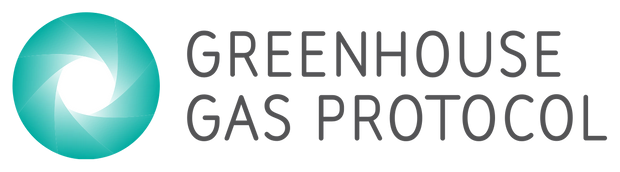

<p>To calculate the carbon footprint of purchased goods and services, we can use the generic view <b>v_effect</b> that is already used to determine Scope 1, Scope 2 and Scope 3 - business travel emissions.</p>
<p>This view must be enriched to identify the right emission factor associated to a purchase event/item. To do so, we join <b>v_effect</b> with the <b>purchase_event</b> table and with <b>protocol_ref</b> table.</p>
<p>  - If a supplier provided a specific emission factor, then supplier_name will match with the protocol name. This emission factor must be selected in priority</p>
<p>  - If a supplier did not provide any emission factor, or if no specific supplier was identified, we select the default emission factor from GHG Protocol example data</p>

In [5]:
-- Detailed output 
select  effect.event_id
       ,effect.scope_number
       ,effect.scope_category_description
       ,effect.activity_id
       ,effect.activity_desc
       ,purchase_evt.supplier_name
       ,effect.protocol_id
       ,effect.co2e_emission
from    ${workingDatabase}.${greenAgendaPrefixe}v_effect effect -- effect view already embeds all the operations and rules to dynamically provide the CO2e emissions (in kg) for every event
inner join
        ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbPurchaseEvt} purchase_evt -- purchase_event will provide information regarding potential suppliers
on      effect.event_id = purchase_evt.event_id
inner join
        ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbProtocolRef} protocol_ref -- protocol_ref provide information regarding emission factors, particularly supplier-specific emission factors
on      effect.protocol_id = protocol_ref.protocol_id
where   effect.activity_id like '3UPG%'  -- We get only events from Scope 3 - Purchased goods and services category
qualify row_number() over (partition by effect.event_id
                           order by     case
                                          when purchase_evt.supplier_name = protocol_ref.protocol_name 
                                          then 1 -- If a supplier provided a specific emission factor, then supplier_name will match with the protocol name. This emission factor must be selected in priority
                                          else 2 -- If a supplier did not provide any emission factor, or if no specific supplier was identified, we select the default emission factor from GHG Protocol example data
                                        end
                          ) = 1
order by purchase_evt.supplier_name
;

,event_id,scope_number,scope_category_description,activity_id,activity_desc,supplier_name,protocol_id,co2e_emission
1,301202201011000013,3,Purchased goods and services,3UPGOOD_PLASTICPS,Purchased goods - plastic (PS),,GHGPEXMPL,1500
2,301202201011000012,3,Purchased goods and services,3UPGOOD_PLASTICABS,Purchased goods - plastic (ABS),,GHGPEXMPL,900
3,301202201011000003,3,Purchased goods and services,3UPGOOD_COPPER,Purchased goods - copper,,GHGPEXMPL,300
4,301202201011000010,3,Purchased goods and services,3UPGOOD_LCD,Purchased goods - LCD (Liquid Crystal Display),,GHGPEXMPL,20000
5,301202201011000001,3,Purchased goods and services,3UPGOOD_ALUMINIUM,Purchased goods - aluminium,,GHGPEXMPL,3000
6,301202201011000011,3,Purchased goods and services,3UPGOOD_PETFILM,Purchased goods - PET (film),,GHGPEXMPL,1200
7,301202201011000004,3,Purchased goods and services,3UPGOOD_CYCLOHEXANE,Purchased goods - cyclohexane,,GHGPEXMPL,1000
8,301202201011000006,3,Purchased goods and services,3UPGOOD_GLASS,Purchased goods - glass,,GHGPEXMPL,2000
9,301202201011000009,3,Purchased goods and services,3UPGOOD_KEYBOARD,Purchased goods - keyboard,,GHGPEXMPL,900
10,301202201011000014,3,Purchased goods and services,3UPGOOD_SEMICONDUCTOR,Purchased goods - semiconductors,,GHGPEXMPL,7000


In [6]:
-- Output agregated by examples for each method in the GHG Protocol
select  case
          when supplier_name in ('Supplier C'
                                ,'Supplier D'
                                ,'Supplier E'
                                ,'Supplier F'
                                ,'Supplier G'
                                )              then 'Example [1.1] - Supplier-specific method'
          when supplier_name =   'Supplier B1' then 'Example [1.2] - Hybrid method'
          when supplier_name =   'Supplier B2' then 'Example [1.3] - Hybrid method'
          when supplier_name is null           then 'Example [1.4] - Average-data method'
        end                                                                                    as example_case
       ,sum(co2e_emission)                                                                     as calculated_co2_emission_kg
from   (select  effect.event_id
               ,effect.scope_number
               ,effect.scope_category_description
               ,effect.activity_id
               ,effect.activity_desc
               ,purchase_evt.supplier_name
               ,effect.protocol_id
               ,effect.co2e_emission
        from    ${workingDatabase}.${greenAgendaPrefixe}v_effect effect -- effect view already embeds all the operations and rules to dynamically provide the CO2e emissions (in kg) for every event
        inner join
                ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbPurchaseEvt} purchase_evt -- purchase_event will provide information regarding potential suppliers
        on      effect.event_id = purchase_evt.event_id
        inner join
                ${workingDatabase}.${greenAgendaPrefixe}${coreTablePrefixe}${tbProtocolRef} protocol_ref -- protocol_ref provide information regarding emission factors, particularly supplier-specific emission factors
        on      effect.protocol_id = protocol_ref.protocol_id
        where   effect.activity_id like '3UPG%'  -- We get only events from Scope 3 - Purchased goods and services category
        qualify row_number() over (partition by effect.event_id
                                   order by     case
                                                  when purchase_evt.supplier_name = protocol_ref.protocol_name 
                                                  then 1 -- If a supplier provided a specific emission factor, then supplier_name will match with the protocol name. This emission factor must be selected in priority
                                                  else 2 -- If a supplier did not provide any emission factor, or if no specific supplier was identified, we select the default emission factor from GHG Protocol example data
                                                end
                                  ) = 1
       ) upg_effect
group by example_case
order by example_case
;

,example_case,calculated_co2_emission_kg
1,Example [1.1] - Supplier-specific method,145000
2,Example [1.2] - Hybrid method,257300
3,Example [1.3] - Hybrid method,70250
4,Example [1.4] - Average-data method,54100


<h2 style="color:#24B598">Supplier specific method</h2>

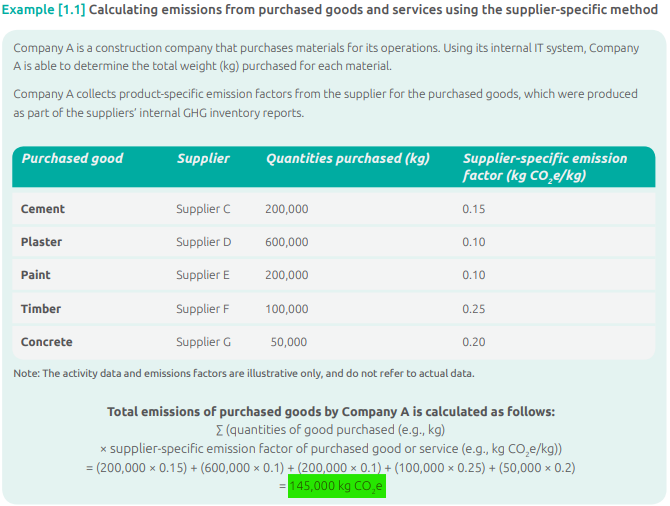

The calculate carbon footprint for this example matches with the data provided by the carbon footprint engine: <b style="color:green">OK</b>

<h2 style="color:#24B598">Hybrid method</h2>

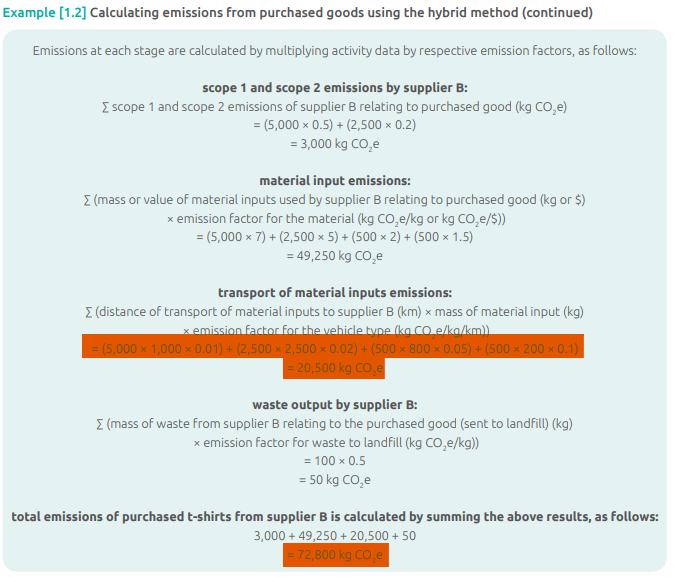

The calculate carbon footprint for this example does not match with the data provided by the carbon footprint engine: <b style="color:red">KO</b>
<p>By observing the items in the detailed view, we can see that the difference occurs in the "<b>transport of material inputs emissions</b> step. The calculation of the GHG Protocol is wrong by a factor 10. The result of the operation is 205K kg CO2e not 25K kg CO2e. So the error actually comes from the GHG Protocol document.</p>

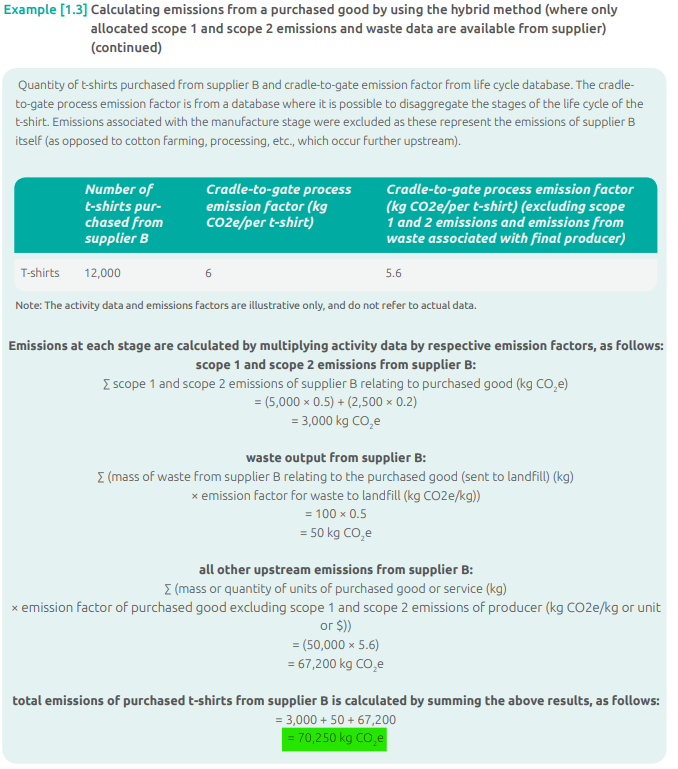

The calculate carbon footprint for this example matches with the data provided by the carbon footprint engine: <b style="color:green">OK</b>

<h2 style="color:#24B598">Average-data method</h2>

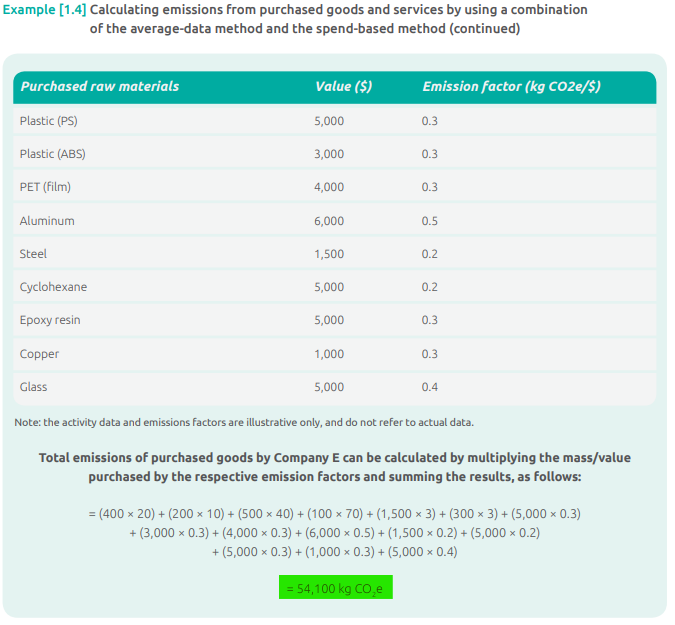

The calculate carbon footprint for this example matches with the data provided by the carbon footprint engine: <b style="color:green">OK</b>